In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#plt.style.use("seaborn")
%matplotlib inline

import warnings
warnings.simplefilter("ignore")
from binance.client import Client
import time
import statistics as stats
from datetime import datetime
import random
import torch
import torch.nn as nn
import mlfinlab
import glob

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
class LSTM(nn.Module):

    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True).to(device)
        self.l1 = nn.Linear(hidden_dim, output_dim).to(device)
        #self.relu = nn.ReLU()

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.shape[0], self.hidden_dim).requires_grad_()
        #h0=h0.to(device)
        c0 = torch.zeros(self.num_layers, x.shape[0], self.hidden_dim).requires_grad_()
        #c0=c0.to(device)
        output, (hn, cn) = self.lstm(x.to(device), (h0.detach().to(device), c0.detach().to(device)))
        #out = self.relu(self.l1(output[:, -1, :]))
        out = self.l1(output[:, -1, :])
        return out

In [4]:
##bbands
##BBANDS(close, timeperiod=25, nbdevup=2, nbdevdn=2, matype=0)
##RSE
##real = RSI(close, timeperiod=14)
##MFI
##real = MFI(high, low, close, volume, timeperiod=14)

##OBV
##real = OBV(close, volume)

##Trange
##real = TRANGE(high, low, close)

In [5]:
df_dict = {}

directory = '../data/final_data' ### directory with final data
all_files = glob.glob(directory + "/*.csv")

for file in all_files:
    
    df = pd.read_csv(file, index_col=None, header=0)
    
    df_dict[file.split('\\')[1][:-10]] = df ### df dictionary with keys ADA, BNB, ...

In [6]:
coin_list = list(df_dict.keys())
print(coin_list)

columns = list(df_dict[coin_list[0]].columns)
not_quant = ['Open Time','Close Time', 'bin'] ### take out label and non-quantitative data 
quants = [i for i in columns if i not in not_quant]

['ADA', 'BNB', 'ETH', 'LINK', 'LTC', 'XRP']


In [7]:
class Create_Sequences():
    def __init__(self, data, seq_len=25): ### feed in df_dict[coin], sequence length
        self.seq_len = seq_len       
        self.sequences = []
        self.data = data
        self.create_sequences()

    def create_sequences(self):
        
        self.data = torch.tensor(self.data[quants].values)
        
        for i in range(self.data.shape[0] - self.seq_len):

            sequence=self.data[i:i+self.seq_len] #i, .., i+seq_len-1, i+seq_len
            self.sequences.append(sequence)
            
        self.sequences=torch.stack(self.sequences)#shape of data - seq_len, sequence length, # of features
       

In [30]:
def separate(data, break_point=.15, window_length=.05, desired_feature=4):
    
    #separate into training, testing data 
    
    upper=int((1-break_point) * data.shape[0]) + int(window_length * data.shape[0])
    lower=int((1-break_point) * data.shape[0]) - int(window_length * data.shape[0])
    
    train_x, train_y = data[:lower, :, :], data[1:lower+1, -1, desired_feature]
    test_x, test_y = data[upper:-1], data[upper+1:, -1, desired_feature]
    
    return train_x, train_y, test_x, test_y

In [9]:
def take_samples(d, k=5_000, test=False):
    
    #choose k samples from each coin dict in li (found below)
    #used in training 
    
    x=[]
    y=[]
    
    for coin in coin_list:
        
        if test:
            _, _, t_x, t_y= d[coin]
        else:
            t_x, t_y, _, _ = d[coin]
            
        indices = random.sample(list(range(0, t_x.shape[0])), k=k)
        
        x.append(t_x[indices])
        y.append(t_y[indices])
    
    x=torch.cat(x)
    y=torch.cat(y)
    
    return x, y

In [10]:
#where to store and extract weights
weights_path='E:/Users/Justin/Desktop/Course Folders 2020/practicum/weights/weights.pth'

In [27]:
def train(optimizer, criterion, model, epochs=10):
    
    time_list=[]   
    
    for _ in range(epochs):
        
        loss_list=[]
        
        start=time.time()
        
        x, y = take_samples(li2)
            
        sequence = x[i].reshape(1, x[i].shape[0], x[i].shape[1]).to(device)
        ret = y[i].to(device)
        #print(1)

        optimizer.zero_grad()
        #model.zero_grad()

        result = model(sequence.float().to(device)).to(device)
        #print(2)
        loss = criterion(result, ret.float())
        loss_list.append(loss)
        #print(3)
        loss.backward()
        #print(4)
        optimizer.step()
        
        #print('here2')
        end=time.time()
        time_list.append(end-start)
        print('Epoch: ', _+1, 'Time: ', end-start, 'Loss: ', sum(loss_list).item())
        to_save=(optimizer, criterion, epochs, model.state_dict(), model)
        torch.save(model.state_dict(), weights_path)


In [12]:
#validating training data
def test(model, data):
    
    time_list=[]
    
    start=time.time()
    
    _, _, test_x, test_y = data
    
    model.load_state_dict(torch.load('weights.pth'))
    
    results=[]
    
    with torch.no_grad():
        
        for i in range(test_x.shape[0]):
            sequence = test_x[i].reshape(1, test_x[i].shape[0], test_x[i].shape[1])
            
            result = model(sequence)
            results.append(result)
    
    end=time.time()
    time_list.append(end-start)
    

In [13]:
li={}
seq_len=25
time_list=[]
for coin in coin_list:
    start=time.time()
    current = Create_Sequences(df_dict[coin], seq_len=seq_len)
    li[coin] = current.sequences
    time_list.append(time.time()-start)
    print(coin)

ADA
BNB
ETH
LINK
LTC
XRP


In [14]:
for coin in coin_list:
    print(coin, li[coin].shape)

ADA torch.Size([51501, 10, 54])
BNB torch.Size([58175, 10, 54])
ETH torch.Size([58195, 10, 54])
LINK torch.Size([54532, 10, 54])
LTC torch.Size([58195, 10, 54])
XRP torch.Size([52854, 10, 54])


In [15]:
li2 = {}
for coin in coin_list:
    li2[coin] = separate(li[coin])
    torch.save(li2[coin], 'E:/Users/Justin/Desktop/Course Folders 2020/practicum/tensors/'+coin+str(seq_len)+'rev_seq.pth')

In [16]:
test_x=[]
test_y=[]
for coin in coin_list:
    _,_, testx, testy = li2[coin]
    test_x.append(testx)
    test_y.append(testy)

In [26]:
input_dim = 54
hidden_dim = 24
n_layers = 5
output_dim = 1

model = LSTM(input_dim, hidden_dim, n_layers, output_dim)

#criterion = nn.CrossEntropyLoss()
criterion = nn.MSELoss(reduction='mean')

optimizer = torch.optim.SGD(model.parameters(), lr=.001)
#optimizer = torch.optim.Adam(model.parameters(), lr=.1)

model=model.to(device)
train(optimizer, criterion, model, 15)

Epoch:  0 Time:  216.17316889762878 Loss:  5.343841075897217
Epoch:  1 Time:  222.67074298858643 Loss:  3.6412644386291504
Epoch:  2 Time:  217.3955261707306 Loss:  3.6367228031158447
Epoch:  3 Time:  218.7867112159729 Loss:  3.6603944301605225
Epoch:  4 Time:  218.49884676933289 Loss:  3.6862566471099854
Epoch:  5 Time:  218.39017844200134 Loss:  3.6381354331970215
Epoch:  6 Time:  218.4815957546234 Loss:  3.620204210281372
Epoch:  7 Time:  218.9376962184906 Loss:  3.6766912937164307
Epoch:  8 Time:  219.28498125076294 Loss:  3.650742292404175
Epoch:  9 Time:  219.38093733787537 Loss:  3.6384129524230957
Epoch:  10 Time:  221.5409824848175 Loss:  3.5860822200775146
Epoch:  11 Time:  283.0771379470825 Loss:  3.6228861808776855
Epoch:  12 Time:  241.55982398986816 Loss:  3.6389379501342773
Epoch:  13 Time:  219.1870141029358 Loss:  3.5215706825256348
Epoch:  14 Time:  217.55157113075256 Loss:  3.539924144744873


In [18]:
li2['ADA'][2].shape

torch.Size([12875, 10, 54])

In [28]:
li3={}

for coin in coin_list:
    result=[]
    model.load_state_dict(torch.load(weights_path))
    with torch.no_grad():
        for i in li2[coin][2]:
            sequence=i.reshape(1, i.shape[0], i.shape[1]).float()
            result.append(model(sequence))
            
    li3[coin]=result

In [20]:
li3['ADA'][0].item()

-0.8063179850578308

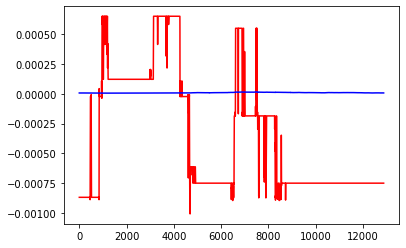

In [29]:
plt.plot(li3['ADA'],color='r')
plt.plot(li2['ADA'][3],color='b')

plt.show()